In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import requests
import numpy as np
model = SentenceTransformer('all-MiniLM-L6-v2')

#libraries

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [2]:
DATA_DIR = "/kaggle/input/indian-government-schemes"
data = []

for state in tqdm(os.listdir(DATA_DIR)):
    state_dir = os.path.join(DATA_DIR, state)
    if os.path.isdir(state_dir):
        for fname in os.listdir(state_dir):
            if fname.endswith(".txt"):
                path = os.path.join(state_dir, fname)
                with open(path, 'r', encoding='utf-8', errors='ignore') as file:
                    text = file.read()
                data.append({
                    "state": state,
                    "scheme_file": fname,
                    "scheme_title": os.path.splitext(fname)[0],
                    "content": text
                })

df = pd.DataFrame(data)
#loading data

  0%|          | 0/29 [00:00<?, ?it/s]

In [3]:
#visualisations
df = pd.DataFrame(data)
df.head()

,state,scheme_file,scheme_title,content
0,bihar,state_bihar_doc_1.txt,state_bihar_doc_1,\nBihar government has launched Jal Jivan Hari...
1,bihar,state_bihar_doc_23.txt,state_bihar_doc_23,\nBihar govt. has now launched Mukhyamantri An...
2,bihar,state_bihar_doc_10.txt,state_bihar_doc_10,\n\n\nTable of Contents\n\nBihar Online Land M...
3,bihar,state_bihar_doc_26.txt,state_bihar_doc_26,\n\n\nTable of Contents\n\nIndia Skills Bihar ...
4,bihar,state_bihar_doc_37.txt,state_bihar_doc_37,\nBihar Student Credit Card scheme is an ambit...


In [4]:
df.tail()

,state,scheme_file,scheme_title,content
1519,chhattisgarh,state_chhattisgarh_doc_2.txt,state_chhattisgarh_doc_2,\nChhattisgarh govt. to start CG Mukhyamantri ...
1520,chhattisgarh,state_chhattisgarh_doc_28.txt,state_chhattisgarh_doc_28,\n\n\nTable of Contents\n\nApplication Form fo...
1521,chhattisgarh,state_chhattisgarh_doc_21.txt,state_chhattisgarh_doc_21,\nChhattisgarh govt. has announced the launch ...
1522,chhattisgarh,state_chhattisgarh_doc_14.txt,state_chhattisgarh_doc_14,\nछत्तीसगढ़ वोटर लिस्ट 2020 (PDF) अब सीईओ की आध...
1523,chhattisgarh,state_chhattisgarh_doc_26.txt,state_chhattisgarh_doc_26,\n\n\nTable of Contents\n\nKey Features of Log...


In [5]:
#the file name doesn't give a hint about the content inside

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   state         1524 non-null   object
 1   scheme_file   1524 non-null   object
 2   scheme_title  1524 non-null   object
 3   content       1524 non-null   object
dtypes: object(4)
memory usage: 47.8+ KB


In [7]:
df.describe()

,state,scheme_file,scheme_title,content
count,1524,1524,1524,1524
unique,29,1524,1524,1444
top,central,state_bihar_doc_1.txt,state_bihar_doc_1,\nPradhan Mantri Awas Yojana – Gramin (PMAY-G)...
freq,205,1,1,14


In [8]:
df.isnull().sum()

state           0
scheme_file     0
scheme_title    0
content         0
dtype: int64

In [9]:
df.dtypes

state           object
scheme_file     object
scheme_title    object
content         object
dtype: object

In [10]:
df.shape

(1524, 4)

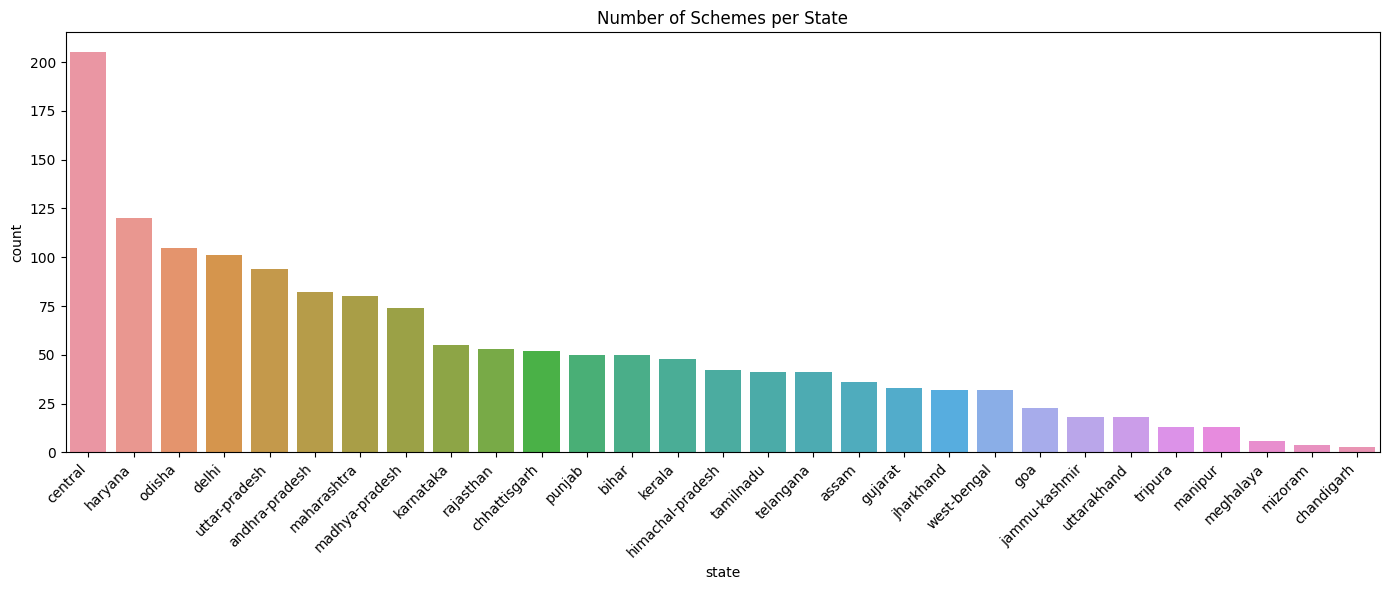

In [11]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x="state", order=df["state"].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Number of Schemes per State")
plt.tight_layout()
plt.show()

In [12]:
#central schemes are the most common

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


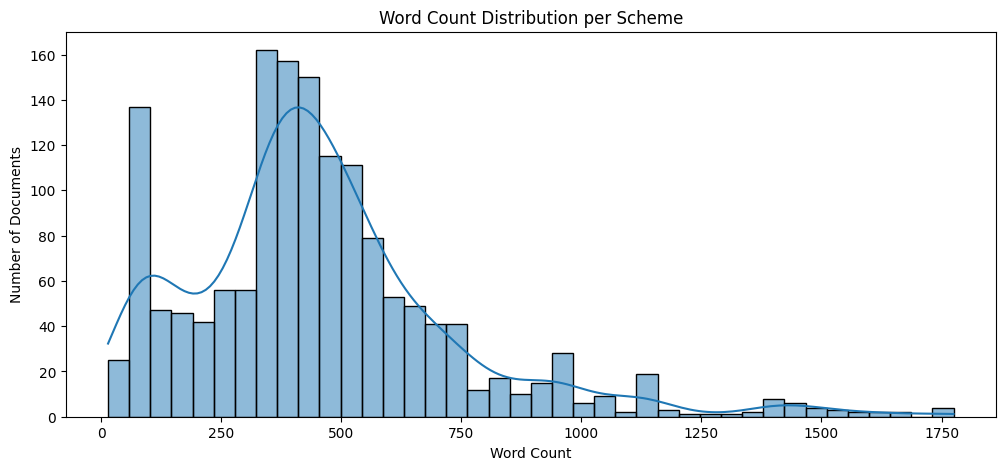

In [13]:
df["word_count"] = df["content"].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
sns.histplot(df["word_count"], bins=40, kde=True)
plt.title("Word Count Distribution per Scheme")
plt.xlabel("Word Count")
plt.ylabel("Number of Documents")
plt.show()


In [14]:
#This shows us frequencies of words (total words) and how many documents have that frequencies

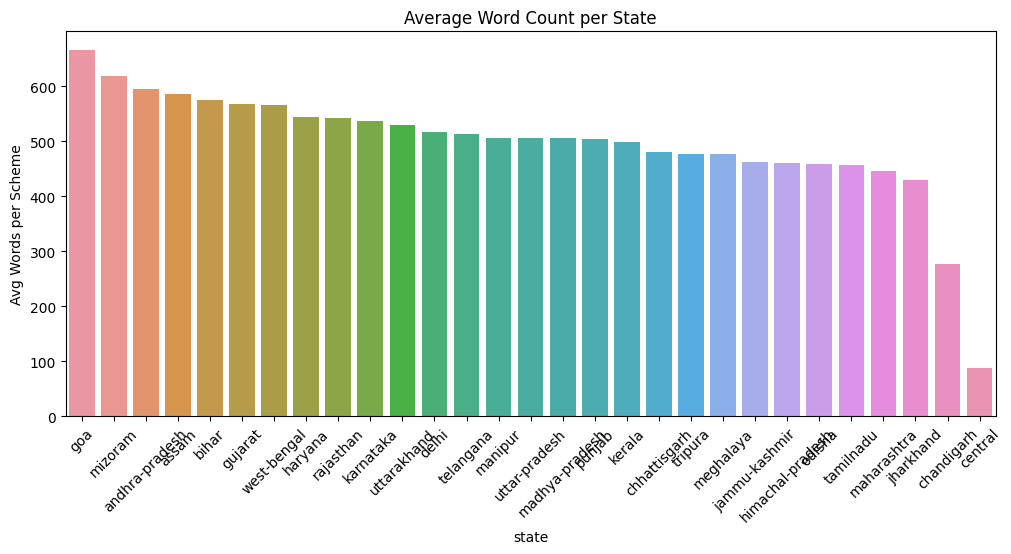

In [15]:
avg_wc = df.groupby("state")["word_count"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=avg_wc.index, y=avg_wc.values)
plt.xticks(rotation=45)
plt.title("Average Word Count per State")
plt.ylabel("Avg Words per Scheme")
plt.show()


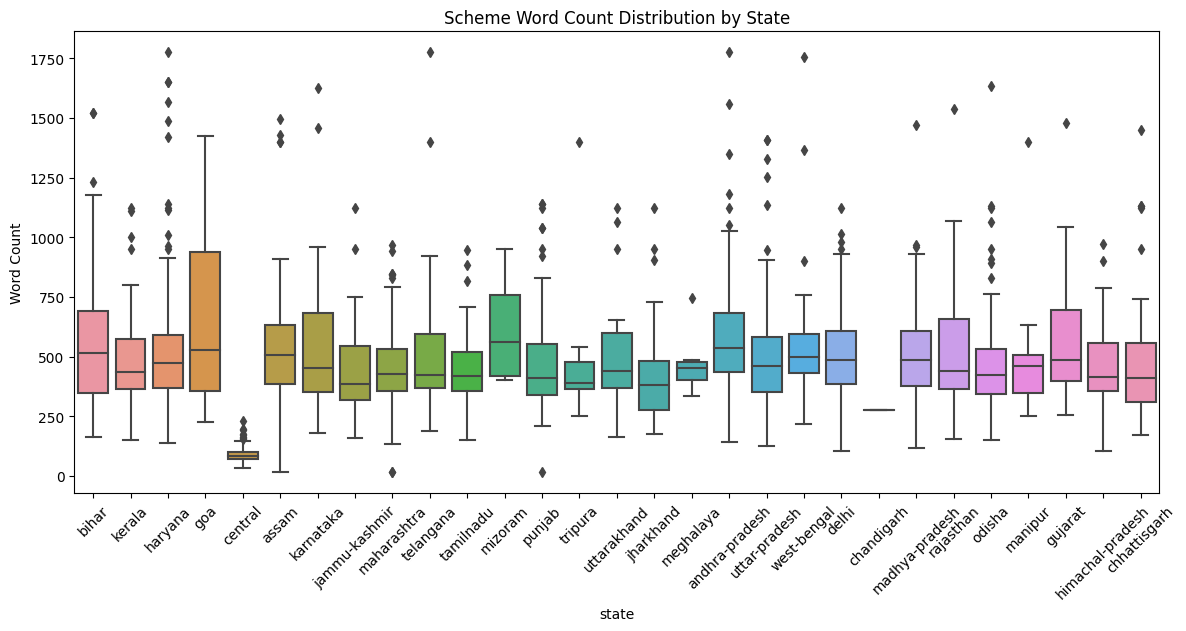

In [16]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="state", y="word_count")
plt.xticks(rotation=45)
plt.title("Scheme Word Count Distribution by State")
plt.ylabel("Word Count")
plt.show() 

In [17]:
top_docs = df.sort_values(by="word_count", ascending=False).head(5)

for _, row in top_docs.iterrows():
    print(f"{row['scheme_title']} ({row['state']}) - {row['word_count']} words")
    print(row['content'][:300] + "...")
    print("="*80) 

state_telangana_doc_7 (telangana) - 1775 words

प्रधान मंत्री फसल बीमा योजना 2020 के लिए ऑनलाइन आवेदन कैसे करें / किसान पंजीकरण कैसे करें, PMFBY के लिए पात्रता, जरूरी दस्तावेजों की सूची, योजना के तहत बीमा राशि के लिए क्लेम कैसे करें और योजना के फ़ायदों के साथ पाएँ योजना के बारे में 

Table of Contents

PM Fasal Bima Yojana Application Form 2020Ho...
state_haryana_doc_107 (haryana) - 1775 words

प्रधान मंत्री फसल बीमा योजना 2020 के लिए ऑनलाइन आवेदन कैसे करें / किसान पंजीकरण कैसे करें, PMFBY के लिए पात्रता, जरूरी दस्तावेजों की सूची, योजना के तहत बीमा राशि के लिए क्लेम कैसे करें और योजना के फ़ायदों के साथ पाएँ योजना के बारे में 

Table of Contents

PM Fasal Bima Yojana Application Form 2020Ho...
state_andhra-pradesh_doc_78 (andhra-pradesh) - 1775 words

प्रधान मंत्री फसल बीमा योजना 2020 के लिए ऑनलाइन आवेदन कैसे करें / किसान पंजीकरण कैसे करें, PMFBY के लिए पात्रता, जरूरी दस्तावेजों की सूची, योजना के तहत बीमा राशि के लिए क्लेम कैसे करें और योजना के फ़ायदों के साथ पाएँ योजना के बारे में 

Table

In [18]:
sample_docs = df.head(20)  
chars_to_show = 300        

for _, row in sample_docs.iterrows():
    print(f"{row['scheme_title']} ({row['state']}) - {row['word_count']} words")
    print(row['content'][:chars_to_show] + "...")
    print("=" * 80)

state_bihar_doc_1 (bihar) - 359 words

Bihar government has launched Jal Jivan Hariyali Campaign to minimize the bad effects of climate change on the lives of people and to protect environment. This abhiyan will be launched on 2 October 2019 which is 150th anniversary of Mahatma Gandhi. Revenue and Land Reforms Department (RLRD) will id...
state_bihar_doc_23 (bihar) - 528 words

Bihar govt. has now launched Mukhyamantri Anusuchit Jati Evam Anusuchit Janjati Civil Seva Protsahan Yojana to help “Mahadalits” to focus on their studies. Under this scheme, all the Scheduled Caste (SC) / Scheduled Tribes (ST) students will get Rs. 50,000 and Rs. 1 Lakh respectively as an assistan...
state_bihar_doc_10 (bihar) - 708 words



Table of Contents

Bihar Online Land Mutation & Payment of Land Tax Facility1. Bihar Online Land Mutation (Dakhil Kharij) Facility2. Check Apna Khata (New Survey) – Land Records by Bihar Government3. Bihar Land Registration Website – Check Property Registry Details
CM Niti

In [19]:
doc = df.sample(1).iloc[0]

print(f"Title: {doc['scheme_title']} ({doc['state']}) - {doc['word_count']} words")
print("="*100)
print(doc['content'])
print("="*100)

Title: state_maharashtra_doc_54 (maharashtra) - 133 words

The revamped mega health insurance scheme of state government of Maharashtra has been re-scheduled to launch on 21st October. Rajiv Gandhi Jeevandayee Arogya Yojana (RGJAY), which was revamped as the Mahatma Jyotiba Phule Jan Arogya Yojana (MJPJAY) in August, was scheduled to be launched last Saturday but the deadline has been missed.
The reasons of the delay are some technical and administrative reasons as reported by the asianage.com.
Under the revamped Mahatma Jyotiba Phule Jan Arogya Yojana (MJPJAY) will provide insurance for over 1100 ailments instead of 900, as was the case in the earlier scheme.



(adsbygoogle=window.adsbygoogle||[]).push({});

However, the doctors in the state civil hospitals are still working as per the older RGJAY scheme.
The complete details about the scheme would be available once the scheme is launched.


(adsbygoogle=window.adsbygoogle||[]).push({});






(adsbygoogle=window.adsbygoogle||[]).pus

In [20]:
docs_with_toc = df[df['content'].str.contains('Table of Contents', case=False, na=False)]

sampled_docs = docs_with_toc.sample(n=20, random_state=42)

pd.set_option('display.max_colwidth', None)

print(f"Random 20 documents with 'Table of Contents': {len(sampled_docs)}\n")

for idx, row in sampled_docs.iterrows():
    lines = row['content'].splitlines()
    para_after_toc = ""
    
    for i, line in enumerate(lines):
        if "table of contents" in line.lower():
            for j in range(i+1, len(lines)):
                if lines[j].strip(): 
                    para_after_toc = lines[j].strip()
                    break
            break  

    print(f"Title: {row['scheme_title']}")
    print(f"State: {row['state']}")
    print("Paragraph after 'Table of Contents':\n")
    print(para_after_toc or "(No content found after TOC)")
    print("="*80 + "\n")


Random 20 documents with 'Table of Contents': 20

Title: state_uttar-pradesh_doc_6
State: uttar-pradesh
Paragraph after 'Table of Contents':

Book My HSRP UPUP High Security Registration Plates (HSRP) Apply OnlineCheck Status of HSRP Registration – Book My HSRP UPGovernment Order on HSRP in UP Verification of Vehicle Details at VAHAN Portal

Title: state_haryana_doc_4
State: haryana
Paragraph after 'Table of Contents':

Haryana Free Laptop Scheme List of BeneficiariesHaryana Free Laptop Distribution Scheme Apply Online FormHaryana Muft Laptop Yojana Implementation

Title: state_madhya-pradesh_doc_56
State: madhya-pradesh
Paragraph after 'Table of Contents':

Objectives of Scheme For Adolescent Girls (SAG)Scheme For Adolescent Services (SAG) – DetailsKSY & SAG Scheme Funds Allocation

Title: state_uttar-pradesh_doc_72
State: uttar-pradesh
Paragraph after 'Table of Contents':

Online Application for UP State Health CardDownload UP State Health Card Application FormCheck Status of State H

In [21]:
#Preprocessing

In [22]:
df["content2"] = df["content"].str.lower()

In [23]:
def keep_english_only_from_text(text):
    if not isinstance(text, str):
        return ""
    words = text.split()
    english_words = [w for w in words if re.fullmatch(r'[a-z]+', w)]
    return " ".join(english_words)

df["content2"] = df["content2"].apply(keep_english_only_from_text)

In [24]:
def remove_noise(text):
    patterns = [
        r'\(adsbygoogle\s*=\s*window\.adsbygoogle\s*\|\|\s*\[\]\)\.push\(\{\}\);',
        r'save as pdf|click here|enter captcha',
        r'\btable of contents\b'
    ]
    
    for p in patterns:
        text = re.sub(p, '', text, flags=re.IGNORECASE)

    lines = text.splitlines()
    cleaned_lines = []

    for line in lines:
        cleaned_lines.append(line)

    return "\n".join(cleaned_lines).strip()

df["content2"] = df["content2"].apply(remove_noise)

In [25]:
df["content2"] = df["content2"].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

In [26]:
df["content2"] = df["content2"].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


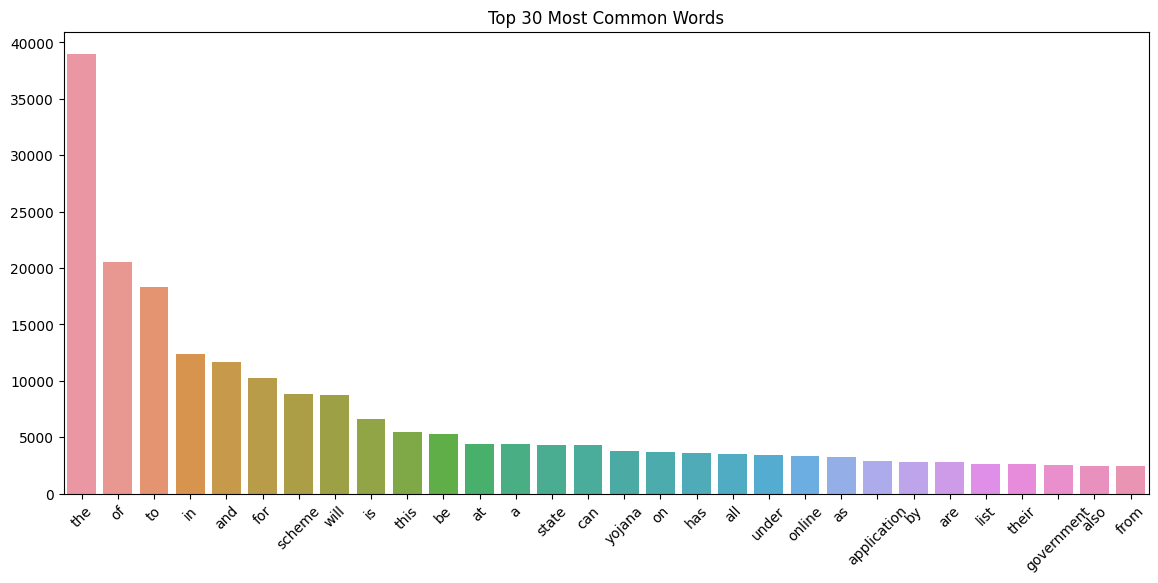

In [27]:
def clean_text(text):
    text = re.sub(r'[^a-z ]', '', text)
    return text

all_words = ' '.join(df['content2'].dropna().apply(clean_text).tolist()).split()
common = Counter(all_words).most_common(30)

words, counts = zip(*common)
plt.figure(figsize=(14, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 30 Most Common Words")
plt.show()

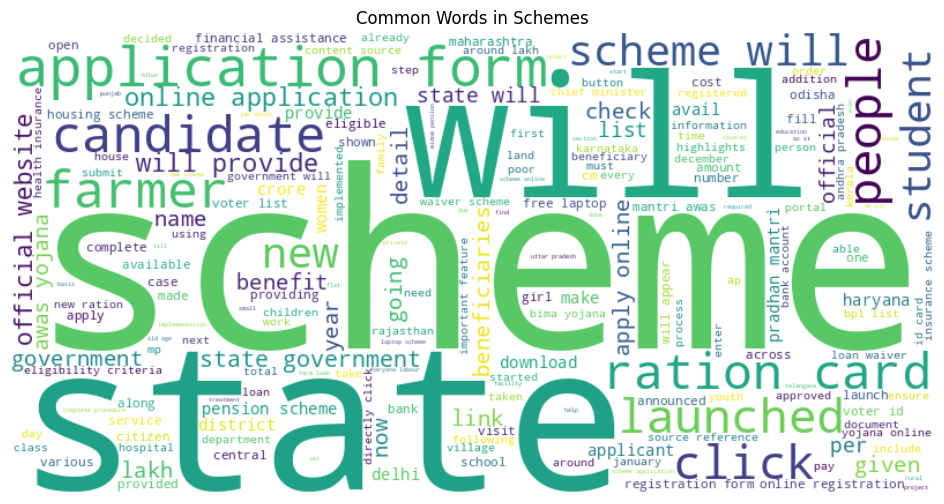

In [28]:
text = " ".join(df["content2"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Schemes")
plt.show()

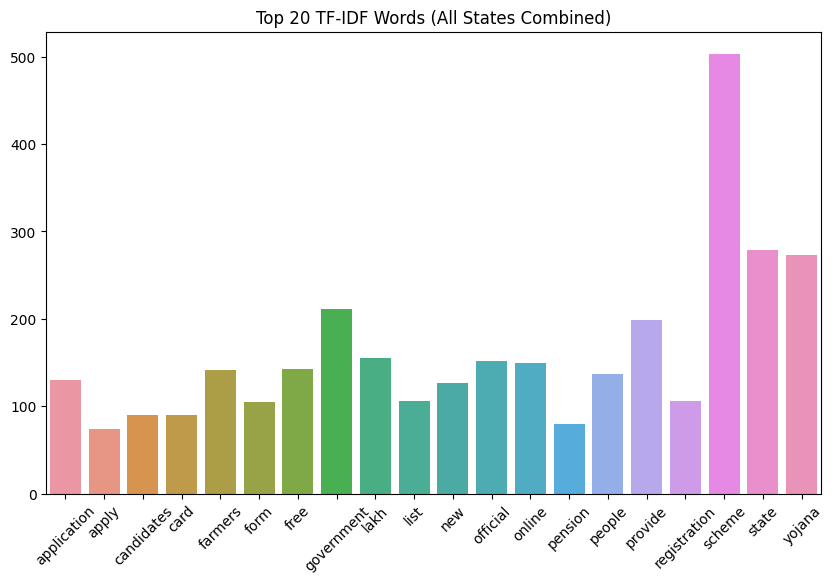

In [29]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df["content2"])
features = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=X.toarray().sum(axis=0))
plt.xticks(rotation=45)
plt.title("Top 20 TF-IDF Words (All States Combined)")
plt.show()

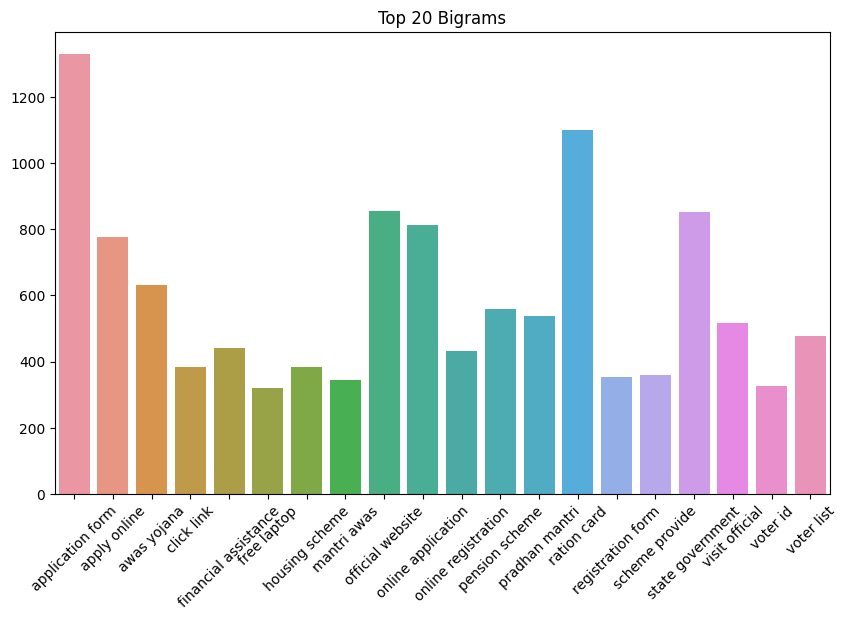

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english", max_features=20)
X = vectorizer.fit_transform(df["content2"])

phrases = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=phrases, y=X.toarray().sum(axis=0))
plt.xticks(rotation=45)
plt.title("Top 20 Bigrams")
plt.show()


In [31]:
#removing some more noise
def remove_noise(text):
    patterns = [
        r'\b(government|new|official|people|scheme|state|yojana)\b', 
    ]
    
    for p in patterns:
        text = re.sub(p, '', text, flags=re.IGNORECASE)

    lines = text.splitlines()
    cleaned_lines = []
    skip_next = False

    for i, line in enumerate(lines):
        if skip_next:
            if line.strip():  
                skip_next = False
            continue

        cleaned_lines.append(line)

    cleaned_text = "\n".join(cleaned_lines).strip()
    
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) 
    cleaned_text = re.sub(r'\n+', '\n', cleaned_text) 

    return cleaned_text

df["content2"] = df["content2"].apply(remove_noise)

In [32]:
df["tokens"] = df["content2"].apply(word_tokenize)

In [33]:
stop_words = set(stopwords.words('english'))

df["tokens"] = df["tokens"].apply(lambda x: [w for w in x if w not in stop_words])

In [34]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(w) for w in x])

In [35]:
import spacy
nlp = spacy.load("en_core_web_sm")
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df["tokens"] = df["tokens"].apply(lambda tokens: lemmatize_text(" ".join(tokens)))

In [37]:
df.to_csv('/kaggle/working/revised_data.csv', index=False)

In [ ]:
import requests
import json

def translate_text(text):
    url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key=apikey"
    
    headers = {
        "Content-Type": "application/json"
    }

    prompt = f"""Translate the following text to English only. Respond only with the translated text and nothing else:

"{text}"
"""

    body = {
        "contents": [
            {
                "parts": [
                    {
                        "text": prompt
                    }
                ]
            }
        ]
    }

    try:
        response = requests.post(url, headers=headers, json=body)
        response.raise_for_status()
        data = response.json()
        response_text = data.get('candidates', [{}])[0].get('content', {}).get('parts', [{}])[0].get('text', 'No response')
        return response_text.strip()
    except requests.exceptions.RequestException as err:
        return f"Error: {err}"



def retrieve_documents(query, df, top_n=3):
    print("\n--- Using MiniLM-L6-v2 Semantic Retrieval ---")

    docs = []
    for i, row in df.iterrows():
        tokens = row["tokens"]
        
        if isinstance(tokens, str):
            tokens = tokens.split()  
        
        joined = " ".join(tokens)
        docs.append(joined)

    print("Total Documents:", len(docs))

    try:
        doc_embeddings = model.encode(docs, convert_to_tensor=True)
        query_embedding = model.encode(query, convert_to_tensor=True)
    except Exception as e:
        print(f"Embedding Error: {e}")
        return df.iloc[0:0]  

    similarities = util.pytorch_cos_sim(query_embedding, doc_embeddings)[0]
    top_indices = similarities.argsort(descending=True)[:top_n]

    print("Top Similarities:", similarities[top_indices])

    return df.iloc[[i.item() for i in top_indices]]



def summarize_text_with_gemini(text):
    url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key=apikey"
    
    headers = {
        "Content-Type": "application/json"
    }

    prompt = f"Summaries the given text based on user query, and return only the summary: \n\"{text}\""

    body = {
        "contents": [
            {
                "parts": [
                    {
                        "text": prompt
                    }
                ]
            }
        ]
    }

    try:
        response = requests.post(url, headers=headers, json=body)
        response.raise_for_status()
        data = response.json()
        summary = data.get('candidates', [{}])[0].get('content', {}).get('parts', [{}])[0].get('text', 'No response')
        
        return summary.strip()

    except requests.exceptions.RequestException as err:
        return f"Error: {err}"


user_query = "kya garibo ki padhai ke liye sarkaar kuch kar rahi hai?"

translated_query = translate_text(user_query)

user_state =  "central"

if user_state:
    filtered_df = df[df["state"] == user_state]
else:
    filtered_df = df 

top_docs = retrieve_documents(translated_query, filtered_df, top_n=3)

combined_text = " ".join(top_docs['tokens'])  
final_summary = summarize_text_with_gemini(f"\nUser Query: {user_query} \nText to explain: {combined_text}")

print(f"Summary: {final_summary}")


--- Using MiniLM-L6-v2 Semantic Retrieval ---
Total Documents: 205


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Top Similarities: tensor([0.3254, 0.2736, 0.2691])
Summary: हाँ, गरीबों की पढ़ाई के लिए सरकार कई प्रयास कर रही है। नई शिक्षा नीति (NEP) का लक्ष्य है कि 2 करोड़ बच्चों को वापस स्कूल लाया जाए, और 3-6 साल के बच्चों के लिए प्रारंभिक शिक्षा पर ध्यान केंद्रित किया जाए। व्यावसायिक शिक्षा कक्षा 6 से शुरू होगी, जिसमें इंटर्नशिप शामिल है। उच्च शिक्षा में 3.5 करोड़ सीटें बढ़ाई जाएंगी, और पाठ्यक्रम लचीला होगा। इसके अतिरिक्त, दीन दयाल उपाध्याय ग्रामीण कौशल योजना (DDU-GKY) ग्रामीण युवाओं को प्रशिक्षित करती है और उन्हें नौकरी प्रदान करती है।
